In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../lite_data/dec15_extracted_domains.csv", header=0)
data.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1950.today,1
1,1,NaN,4lakhdenahoga.com,2
2,2,NaN,aajtak.in,32
3,3,NaN,abc.net.au,1
4,4,NaN,abplive.com,20


In [3]:
data2 = pd.read_csv("../lite_data/aap_dec15_extracted_domains.csv", header=0)
data2.head()

,Unnamed: 0,author,domain,count
0,0,NaN,1.si,1
1,1,NaN,54.xn--h2brj9c,1
2,2,NaN,5dariyanews.com,1
3,3,NaN,aajtak.in,8
4,4,NaN,aamaadmiparty.org,1


In [4]:
data = pd.concat([data, data2])

In [5]:
print(len(data))
print(len(data.dropna(subset=['author'])))

69042
68463


In [6]:
data = data.dropna(subset=['author'])

In [7]:
data.head()

,Unnamed: 0,author,domain,count
411,411,01Bidar,drivespark.com,1
412,412,01Bidar,indiatoday.in,1
413,413,01Bidar,livehindustan.com,1
414,414,01Bidar,prajavani.net,4
415,415,01Bidar,shrts.in,1


In [8]:
data.sample(5)

,Unnamed: 0,author,domain,count
2044,2044,AhbaabGrewal,ndtv.com,1
5464,5464,BJPVinodSonkar,indiatimes.com,9
7760,7760,ChetanVRTarale,newsdanka.com,1
8553,8553,Deodhar,wa.me,1
10712,10712,GHRabari,t.co,1


In [9]:
#map author and party handle
import glob
from collections import Counter, defaultdict

datafiles = glob.glob("/home/phadke/ONR/ONR/big_data/Twitter/*.csv")
author2party = defaultdict()

for d in datafiles:
    splitfilename = d.replace(".csv", "").split("_")
    party = splitfilename[len(splitfilename)-1]
    author = splitfilename[len(splitfilename)-2]
    author2party[author] = party
    

In [10]:
author2party

defaultdict(None,
            {'s': 'BJP',
             'shailesh30cvru': 'INC',
             'buta': 'AAP',
             'rakeshrjnair': 'BJP',
             'AzadmanojBjp': 'BJP',
             'DipakRelon': 'BJP',
             'sanjaypaswanbjp': 'BJP',
             'AAPHrKarnal': 'AAP',
             'ASKollapur': 'INC',
             'deeppant2': 'AAP',
             'SinghViveknsui': 'INC',
             'harnamsingh5968': 'INC',
             'SunitaDuggal7': 'BJP',
             'Naveen1177': 'INC',
             'aap': 'AAP',
             'phaisring96': 'BJP',
             'RitaBJoshi': 'BJP',
             'sidhagrwlbjp': 'BJP',
             'ArpitThakurBJP': 'BJP',
             'S': 'INC',
             'GauravJ8928': 'INC',
             'manthanp96': 'BJP',
             'SavanBarot77': 'BJP',
             'AnkitSSangwan': 'BJP',
             'neuroayush': 'INC',
             'AhrariShahlaINC': 'INC',
             'IamPrabalPBorah': 'BJP',
             'RahulPawarncp': 'INC',
          

In [11]:
len(author2party.keys())

6393

In [12]:
data['party'] = data['author'].apply(lambda x: author2party[x])

In [13]:
data.sample(5)

,Unnamed: 0,author,domain,count,party
39790,39790,chhikaravikas9,wsj.com,1,INC
25160,25160,RajeshMunat,shubhsanket.org,1,BJP
56923,56923,sanyogs,mygov.in,2,INC
13465,13465,INCShauryaveer,nationalheraldindia.com,1,INC
23213,23213,Prakhardubeybjp,financialexpress.com,3,BJP


In [14]:
print(Counter(data[['author','party']].drop_duplicates()['party'].tolist()))

Counter({'BJP': 2531, 'INC': 2214, 'AAP': 340})


### create co-sharing network

In [15]:
link_list = data.groupby("domain")['author'].apply(list).reset_index()
link_list.head()

,domain,author
0,00.pm,[abvpjnu]
1,06-jun-20.click,[MahendrNimbarte]
2,1.am,[swamyb2r]
3,1.as,"[BjpAchary, BorkarAnil]"
4,1.book,"[Bharat, BjpSanjayGupta, RKpanday1977, Umakant..."


In [16]:
link_list['authorsize'] = link_list['author'].apply(lambda x: len(set(x)))
print(len(link_list))
print(len(link_list.loc[link_list['authorsize']>1]))

8129
2575


In [17]:
multiple_shared_domains = link_list.loc[link_list['authorsize']>3]
multiple_shared_domains.head()

,domain,author,authorsize
4,1.book,"[Bharat, BjpSanjayGupta, RKpanday1977, Umakant...",12
6,1.free,"[BJP4TiruvallurW, BJPMahilaMorcha, MaheswaranB...",7
13,1.pm,"[BainslaVishal, Deshmukh, LawyerPriyank, MDSid...",8
52,2.help,"[Bharat, BjpSanjayGupta, RKpanday1977, Umakant...",12
62,2.xn--h2brj9c,"[Pawan4Youth, SevadalSAW, ShahiPratap, pchandr...",4


In [18]:
nodes = defaultdict()
edges = defaultdict()

for idx, row in multiple_shared_domains.iterrows():
    authorlist = list(set(row['author']))
    for a in authorlist:
        if a not in nodes:
            nodes[a] = 1
        else:
            nodes[a]+=1
            
    for i in range(len(authorlist)-1):
        for j in range(i+1, len(authorlist)):
            edgetuple = sorted([authorlist[i], authorlist[j]])
            if (edgetuple[0], edgetuple[1]) not in edges:
                edges[(edgetuple[0], edgetuple[1])] = 1
            else:
                edges[(edgetuple[0], edgetuple[1])] +=1
                
                
            

In [19]:
sorted(['imnitinmudgal','YogeshAttray'])

['YogeshAttray', 'imnitinmudgal']

In [20]:
edges

defaultdict(None,
            {('Bharat', 'vijai63'): 3,
             ('chetaan85', 'vijai63'): 14,
             ('UmakantaSharma3', 'vijai63'): 12,
             ('BjpSanjayGupta', 'vijai63'): 7,
             ('igajendarsingh', 'vijai63'): 6,
             ('Vijendradt', 'vijai63'): 6,
             ('sunilshrirambjp', 'vijai63'): 6,
             ('RKpanday1977', 'vijai63'): 25,
             ('deepakmhaskey', 'vijai63'): 5,
             ('sumeetbhasin', 'vijai63'): 24,
             ('abhayvermabjp', 'vijai63'): 19,
             ('Bharat', 'chetaan85'): 2,
             ('Bharat', 'UmakantaSharma3'): 2,
             ('Bharat', 'BjpSanjayGupta'): 2,
             ('Bharat', 'igajendarsingh'): 2,
             ('Bharat', 'Vijendradt'): 2,
             ('Bharat', 'sunilshrirambjp'): 2,
             ('Bharat', 'RKpanday1977'): 2,
             ('Bharat', 'deepakmhaskey'): 2,
             ('Bharat', 'sumeetbhasin'): 2,
             ('Bharat', 'abhayvermabjp'): 3,
             ('UmakantaSharma3', '

In [23]:
import networkx as nx

G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], party=author2party[n])
    
ndlist = []
    
for e in edges:
    if edges[e] > 10:
        if e[0] not in ndlist:
            G.add_node(e[0], size=nodes[e[0]], party=author2party[e[0]])
            ndlist.append(e[0])
        if e[1] not in ndlist:
            G.add_node(e[1], size=nodes[e[1]], party=author2party[e[1]])
            ndlist.append(e[1])

        G.add_edge(e[0], e[1], weight=edges[e])

In [24]:
nx.write_gexf(G, "./multiparty_domainshares.gexf", encoding='utf-8')

### build common domain network

In [23]:
domlabel = data[['author','domain','party']].drop_duplicates()
domlabel.head()

,author,domain,party
411,01Bidar,drivespark.com,INC
412,01Bidar,indiatoday.in,INC
413,01Bidar,livehindustan.com,INC
414,01Bidar,prajavani.net,INC
415,01Bidar,shrts.in,INC


In [24]:
domain_by_party = domlabel.groupby(['domain','party']).size().reset_index()
domain_by_party.head()

,domain,party,0
0,00.pm,BJP,1
1,06-jun-20.click,INC,1
2,1.am,INC,1
3,1.as,BJP,2
4,1.book,BJP,11


In [25]:
domain_formated = pd.pivot_table(domain_by_party, values=0, index='domain', columns='party').reset_index()
domain_formated.head()

party,domain,BJP,INC
0,00.pm,1.0,NaN
1,06-jun-20.click,NaN,1.0
2,1.am,NaN,1.0
3,1.as,2.0,NaN
4,1.book,11.0,1.0


In [26]:
domain_formated = domain_formated.fillna(0)

In [27]:
domain_formated.sample(5)

party,domain,BJP,INC
5658,rightnewsonline.com,0.0,1.0
1338,com.college,0.0,1.0
5763,sahi.tab,0.0,1.0
4730,nftmall.io,0.0,1.0
4834,oaklandinstitute.org,0.0,1.0


In [28]:
def prop_inclination(row):
    return float(row['BJP'])/float(row['BJP']+row['INC'])

domain_formated['domain_value'] = domain_formated.apply(lambda x: prop_inclination(x), axis=1)
domain_formated.head()

party,domain,BJP,INC,domain_value
0,00.pm,1.0,0.0,1.000000
1,06-jun-20.click,0.0,1.0,0.000000
2,1.am,0.0,1.0,0.000000
3,1.as,2.0,0.0,1.000000
4,1.book,11.0,1.0,0.916667


In [29]:
domain_formated.sample(5)

party,domain,BJP,INC,domain_value
2817,huffingtonpost.in,7.0,34.0,0.170732
3927,mahanews24x7.com,1.0,1.0,0.500000
3107,informistmedia.com,0.0,1.0,0.000000
3847,longdom.org,1.0,0.0,1.000000
2166,fastnewsharpal.com,1.0,0.0,1.000000


<AxesSubplot:ylabel='Frequency'>

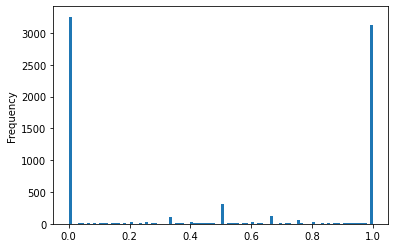

In [31]:
domain_formated.domain_value.plot(kind='hist', bins=100)

In [32]:
domainvalues = domain_formated.set_index("domain").to_dict()['domain_value']
domainvalues

{'00.pm': 1.0,
 '06-jun-20.click': 0.0,
 '1.am': 0.0,
 '1.as': 1.0,
 '1.book': 0.9166666666666666,
 '1.do': 1.0,
 '1.free': 1.0,
 '1.how': 0.0,
 '1.is': 0.0,
 '1.it': 0.0,
 '1.name': 0.0,
 '1.no': 1.0,
 '1.pm': 0.5,
 '1.to': 0.0,
 '1.ug': 1.0,
 '1.xn--54b7fta0cc': 1.0,
 '1.xn--h2brj9c': 1.0,
 '1.xn--i1b6b1a6a2e': 1.0,
 '1.xn--xkc2dl3a5ee0h': 0.0,
 '1.you': 1.0,
 '1.youtube': 1.0,
 '10.am': 1.0,
 '10.km': 0.0,
 '10.pm': 0.0,
 '100.cr': 0.0,
 '1000sq.km': 0.0,
 '101.my': 1.0,
 '1030.pm': 1.0,
 '10am.my': 0.0,
 '10janpath.how': 0.0,
 '11.am': 0.0,
 '11.pm': 0.0,
 '11thadmission.org.in': 0.0,
 '11xi.in': 0.5,
 '12.fail': 0.0,
 '12.how': 0.0,
 '123apps.com': 1.0,
 '128.gb': 1.0,
 '135.cr': 0.0,
 '1843magazine.com': 0.0,
 '19.today': 0.0,
 '1901.it': 1.0,
 '1921malabarmartyrs.com': 1.0,
 '1950.today': 0.0,
 '196.no': 1.0,
 '1cg.in': 0.0,
 '1drv.ms': 0.0,
 '1newsnation.com': 1.0,
 '1sec.me': 0.0,
 '1stbharatnews.com': 0.3333333333333333,
 '2.cr': 0.0,
 '2.help': 0.9166666666666666,
 '2.how': 

In [33]:
domain_list = data.groupby("author")['domain'].apply(list).reset_index()
domain_list.head()

,author,domain
0,01Bidar,"[drivespark.com, indiatoday.in, livehindustan...."
1,02,"[abplive.com, expert.so, forms.gle, indiatoday..."
2,0403,"[abplive.com, amarujala.com, amitshah.co.in, b..."
3,07,[pscp.tv]
4,07Sharma4u,"[abplive.com, amazon.in, champions.gov.in, pmi..."


In [35]:
domain_list['domainsize'] = domain_list['domain'].apply(lambda x: len(set(x)))
print(len(domain_list))
print(len(domain_list.loc[domain_list['domainsize']>10]))

4746
1996


In [36]:
multiple_shared_authors = domain_list.loc[domain_list['domainsize']>10]
multiple_shared_authors.head()

,author,domain,domainsize
2,0403,"[abplive.com, amarujala.com, amitshah.co.in, b...",22
5,0914,"[abplive.com, abpnadu.com, archive.is, breezys...",83
6,1,"[abvp.org, app.link, bhaskar.com, bhaskarhindi...",15
7,100,"[aajtak.in, abcn.ws, abplive.com, altnews.in, ...",57
8,1010,"[asiavillenews.com, bbc.com, bhaskar.com, ex.m...",12


In [37]:
nodes = defaultdict()
edges = defaultdict()

for idx, row in multiple_shared_authors.iterrows():
    authorlist = list(set(row['domain']))
    for a in authorlist:
        if a not in nodes:
            nodes[a] = 1
        else:
            nodes[a]+=1
            
    for i in range(len(authorlist)-1):
        for j in range(i+1, len(authorlist)):
            edgetuple = sorted([authorlist[i], authorlist[j]])
            if (edgetuple[0], edgetuple[1]) not in edges:
                edges[(edgetuple[0], edgetuple[1])] = 1
            else:
                edges[(edgetuple[0], edgetuple[1])] +=1


In [40]:
import networkx as nx

G = nx.Graph()

# for n in nodes.keys():
#     G.add_node(n, size=nodes[n], value=domainvalues[n])

ndlist = []
    
for e in edges:
    if edges[e] > 5:
        if e[0] not in ndlist:
            G.add_node(e[0], size=nodes[e[0]], party=domainvalues[e[0]])
            ndlist.append(e[0])
        if e[1] not in ndlist:
            G.add_node(e[1], size=nodes[e[1]], party=domainvalues[e[1]])
            ndlist.append(e[1])

        
        G.add_edge(e[0], e[1], weight=edges[e])

In [41]:
nx.write_gexf(G, "./dec15_domainsims.gexf", encoding='utf-8')